In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd

import model_predict
from sklearn.model_selection import train_test_split

In [2]:
series, scaler = model_predict.read_data_series(scale=True, filter_early=True, file_index=2)

时间序列不连贯，缺失的月份： ['2013-11', '2014-12', '2015-04', '2017-12']
即将填充缺失的月份
月份平均：
月份
1     165.417333
2     107.969333
3      95.301778
4     123.181000
5     154.631111
6     202.507111
7     136.807500
8     117.749000
9     157.433000
10    156.723500
11    156.563429
12    136.816000
Name: 销量（箱）, dtype: float64


In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.cn = nn.Linear(12, 12)
        self.gru = nn.GRU(input_size + 1, hidden_size,
                          num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch, length, 3]
        x1 = x[:, :, 0].unsqueeze(2).permute(0, 2, 1)
        x1 = self.cn(x1)
        x = torch.cat([x, x1.permute(0, 2, 1)], dim=-1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out


model_parameters = {
    "input_size": 3, "hidden_size": 16, "num_layers": 1, "output_size": 1
}

In [4]:
from importlib import reload
reload(model_predict)
model_predict.train_rnn_model(GRUModel, model_parameters, series, test_shuffle=True, epochs=600)

训练 GRUModel 模型
结果保存到： GRUModel_best.pth
Epoch [50/600], Learn Rate: 1.0000e-03, Training Loss: 0.5752, Validation Loss: 1.0942
Epoch [100/600], Learn Rate: 1.0000e-03, Training Loss: 0.2794, Validation Loss: 1.2486
Epoch [150/600], Learn Rate: 1.0000e-03, Training Loss: 0.2099, Validation Loss: 1.2774
Epoch [200/600], Learn Rate: 1.0000e-03, Training Loss: 0.1233, Validation Loss: 1.2887
Epoch [250/600], Learn Rate: 1.0000e-03, Training Loss: 0.0325, Validation Loss: 1.3609
Epoch [300/600], Learn Rate: 1.0000e-03, Training Loss: 0.0039, Validation Loss: 1.4766
Epoch [350/600], Learn Rate: 1.0000e-03, Training Loss: 0.0006, Validation Loss: 1.5403
Epoch [400/600], Learn Rate: 1.0000e-03, Training Loss: 0.0001, Validation Loss: 1.5703
Epoch [450/600], Learn Rate: 1.0000e-03, Training Loss: 0.0000, Validation Loss: 1.5842
Epoch [500/600], Learn Rate: 1.0000e-03, Training Loss: 0.0000, Validation Loss: 1.5914
Epoch [550/600], Learn Rate: 5.0000e-04, Training Loss: 0.0000, Validation Loss: 

从2017年6月开始后续数据推理
MSE: 2659.48
MAE: 33.61
R^2: 0.47
MAPE: 0.38


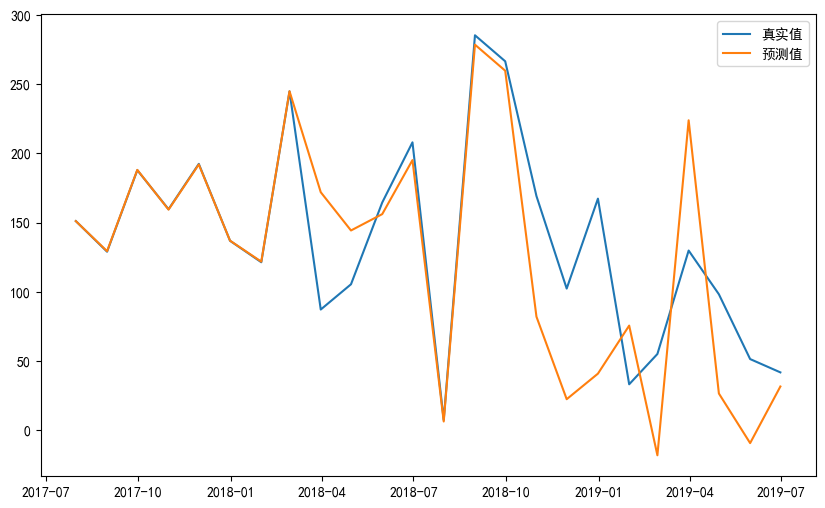

2017-07-31    151.019420
2017-08-31    129.305738
2017-09-30    187.996809
2017-10-31    159.326424
2017-11-30    191.906379
2017-12-31    136.905646
2018-01-31    121.774008
2018-02-28    244.775981
2018-03-31    171.881161
2018-04-30    144.261464
2018-05-31    156.076534
2018-06-30    195.073375
2018-07-31      6.374873
2018-08-31    278.396316
2018-09-30    259.597842
2018-10-31     82.040339
2018-11-30     22.465867
2018-12-31     40.914234
2019-01-31     75.601700
2019-02-28    -18.017016
2019-03-31    223.804860
2019-04-30     26.582108
2019-05-31     -9.233742
2019-06-30     31.631742
Freq: M, dtype: float64

In [5]:
model = model_predict.load_rnn_model_best(GRUModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler, last_months=24)